My aim in this notebook (besides playing around for the first time with a Kaggle notebook :-) ) is to get a sense of what precision can be obtained by using simple optics/geometry (assuming the detection itself will be achieved by DL)
Since there is no description of how the Ground Truth dabase was built, I can think of two options:
1. By means of a LIDAR - in this case, since its spatial resolution is low, there is uncertainty of which point on a target vehicle was actually measured (top, front, side door, etc.). Add to that the measurement precision itself => the challenge requirements are quite strict
2. Estimated by some algorithm => resulting in this challenge being about the ability to learn/imitate its behavior 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2
import os

DATASET_DIR = '/kaggle/input/pku-autonomous-driving/'
train = pd.read_csv(os.path.join(DATASET_DIR, 'train.csv'))
 



The average image:

In [ ]:
# Average Image
fname = train['ImageId'][0]
fpath = os.path.join(DATASET_DIR, 'train_images', '{}.{}'.format(fname, 'jpg'))
img = cv2.imread(fpath)
(R, C) = img.shape[:2]
totFrames = len(train)
averImg = np.zeros((R,C))

for fname in train['ImageId']:
    fpath = os.path.join(DATASET_DIR, 'train_images', '{}.{}'.format(fname, 'jpg'))
    img = cv2.imread(fpath)
    averImg += cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/totFrames

plt.imshow(averImg, cmap = 'gray')
plt.show  

What I learn from this:
* The fact that the test vehicle appears sharp in the average image indicates that the camera is quite stable and there is no systematic left-right image flipping in the database
* A good indication about the location of the horizon/vanishing point, usable for 'old school' distance estimation

In [ ]:
#  Y/Z Analysis
prediction_strings_expanded = train['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
y = prediction_strings_expanded[:,5]
y = y[~np.isnan(y)]
z = prediction_strings_expanded[:,6]
z = z[~np.isnan(z)]
y = y[z<100]
z = z[z<100]
line_fit = np.polyfit(z,y,1)
y_fit = z*line_fit[0] + line_fit[1]
plt.plot(z,y,'b.')
plt.plot(z, y_fit,'r')
plt.grid(b = True)
plt.title(f' y_fit = {line_fit[0]} * z + {line_fit[1]}')
plt.ylabel('y')
plt.xlabel('z')
plt.show

If the optical axis of the camera would have been parallel to the road plane, I would expect the Y values to have low variability, certainly not correclated with Z. The correlation indicates the pitch of the camera relative to the road plane. Also indicated by the location of the horizon.

In order to get a subjective impression of the precision of the ground truth, let's use some 'quick and dirty' modification of the code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car, to display Z values of the labeled cars in some images

In [ ]:
from math import sin, cos
# Utility functions
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    return img_xs, img_ys
   
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image

def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
    return image

def visualize(img, coords):
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
#        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
        cv2.putText(img, str(int(z)), (img_cor_points[-1,0], img_cor_points[-1,1]), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 3, cv2.LINE_AA)
    
    return img

fname = 'ID_0a1d250a1' 
fpath = os.path.join(DATASET_DIR, 'train_images', '{}.{}'.format(fname, 'jpg'))
img = cv2.imread(fpath)
image_idx = train.loc[train['ImageId'] == fname].index[0]
img_vis = visualize(img, str2coords(train['PredictionString'][image_idx]))
plt.figure(figsize=(20,20))
plt.imshow(img_vis)
plt.title('integer part of Z values')
plt.show

I saved and croped details from a few images. I'll just leave them here, with no comments
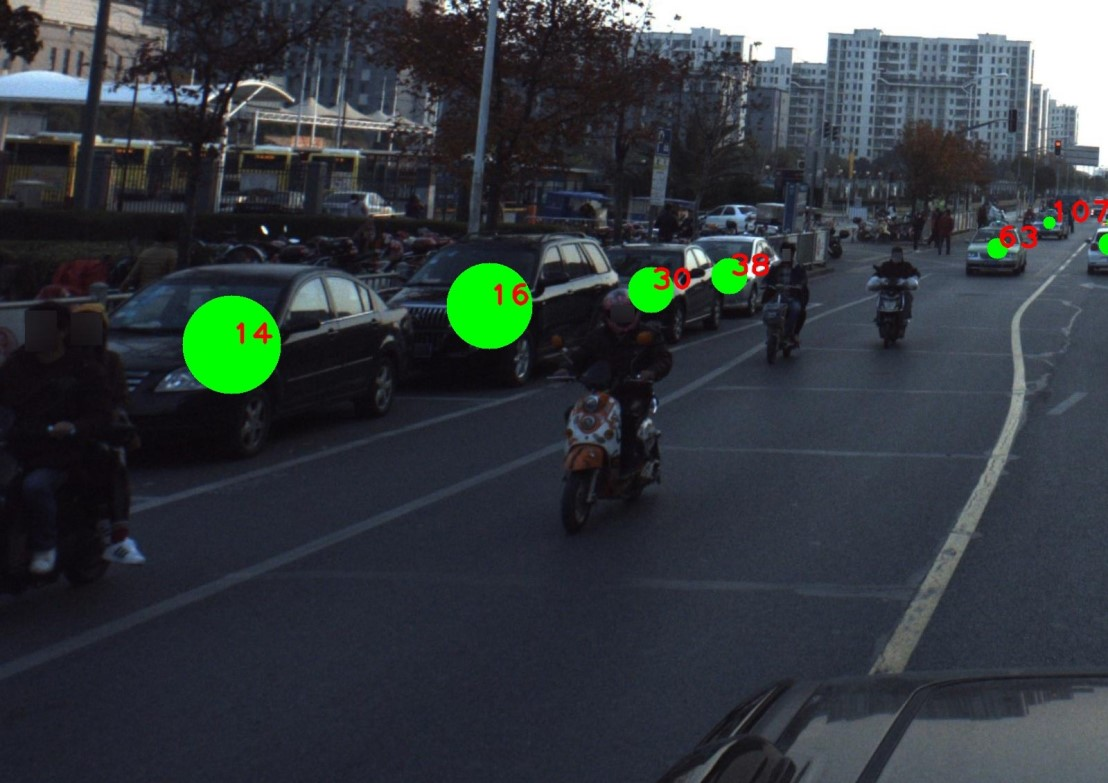
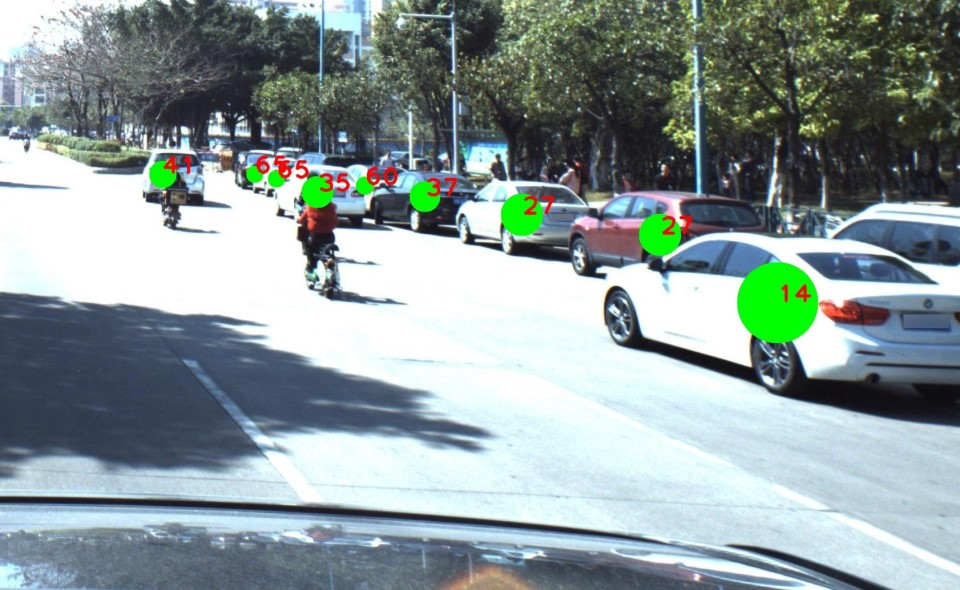
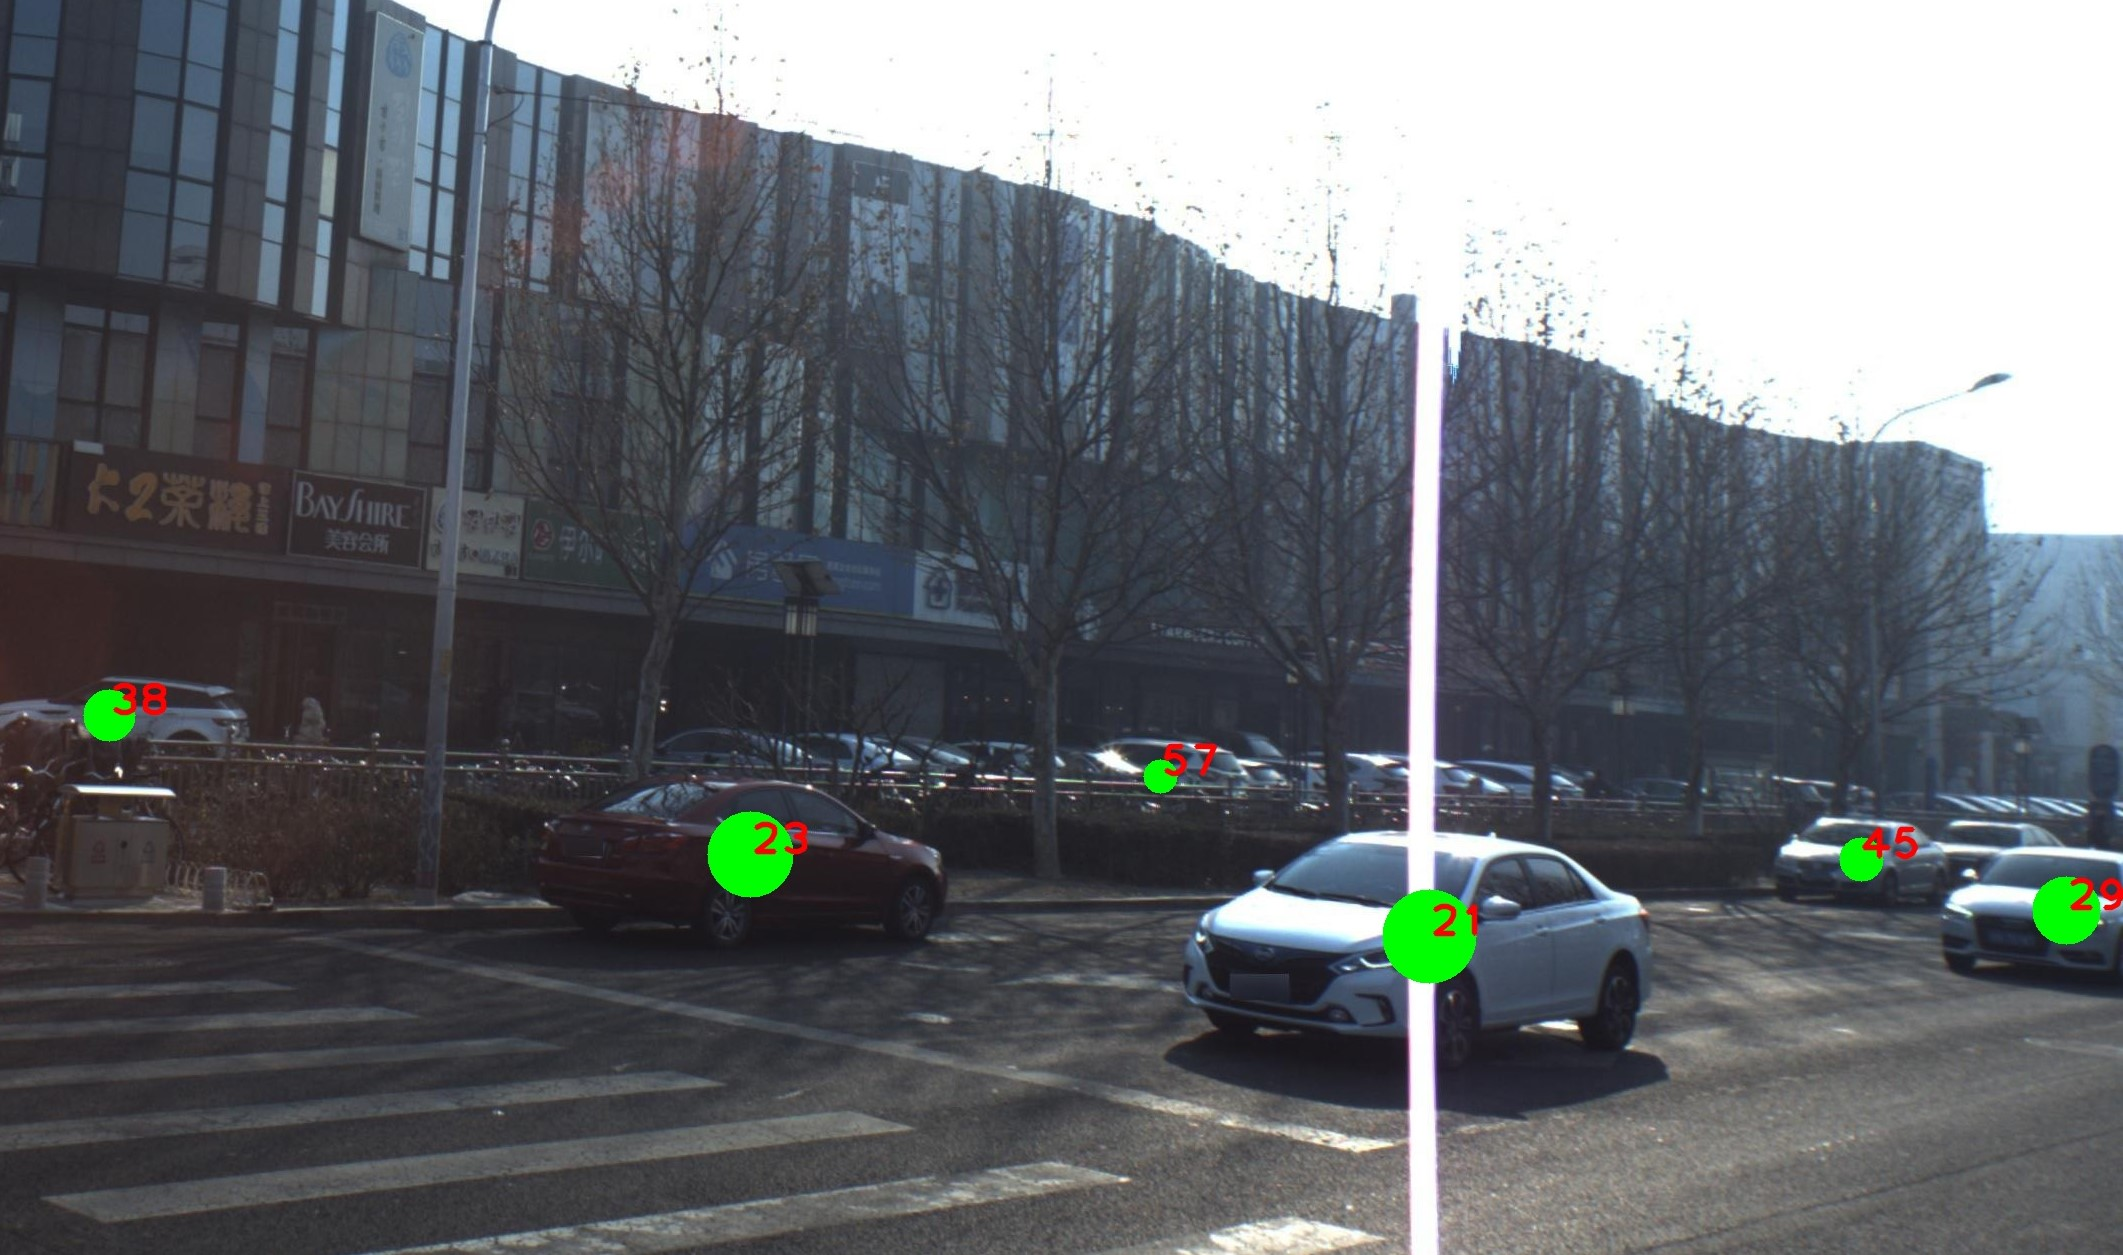